In [150]:
from datetime import datetime
from utils import get_pg_engine
import pandas as pd
import numpy as np

In [124]:
def clean_and_format(start_date = '2019-01-01', end_date = datetime.now().strftime('%Y-%m-%d'), num_stocks = 1000):
    

    assert num_stocks > 20, 'To build an interesting analysis, make sure the number of stocks to use is at least 20'

    start_date_fmt = datetime.strptime(start_date, '%Y-%m-%d')
    end_date_fmt = datetime.strptime(end_date, '%Y-%m-%d')
    diff = end_date_fmt - start_date_fmt
    assert int(diff.days/7) > 12, 'For more meaningful correlations increase the window between the start_date and end_date (at least 12 weeks)'

    engine = get_pg_engine()

    engine.execute("CREATE TABLE IF NOT EXISTS correlations (window_id text, start_date date, end_date date, symbol_a text, symbol_b text, correlation double precision)")

    stocks = pd.read_sql(f'select symbol, sum(volume) as volume \
                       from price \
                       where timestamp between \'{start_date}\' and \'{end_date}\' \
                       group by symbol \
                       order by sum(volume) desc \
                       limit {num_stocks}', engine)
    
    relevant_stocks = ','.join([f"'{stock}'" for stock in stocks['symbol'].tolist()])

    price_data = pd.read_sql(f"select timestamp, symbol, open as price\
                            from price\
                            where \"timestamp\" between \'{start_date}\' and \'{end_date}\'\
                            and symbol in ({relevant_stocks})", engine)

    price_data = price_data.pivot(index='timestamp', columns='symbol', values='price')
    drop_stocks = price_data.isna().apply('mean').sort_values(ascending=False).reset_index()\
    .rename(columns={0:'nas'}).query('nas > 0.65')
    print(f"Will drop {len(drop_stocks)} stocks from the total list, dropping high missing values")
    
    price_data = price_data.loc[:,~price_data.columns.isin(drop_stocks['symbol'])]
    
    print(f"Now cleaning dates")
    keep_dates = pd.Series(price_data.index).reset_index()\
    .assign(dow = lambda df: pd.to_datetime(df['timestamp']).dt.day_name()).query('dow == "Friday"')
    price_data = price_data.fillna(method='ffill')
    price_data = price_data.loc[price_data.index.isin(keep_dates['timestamp'])]
    
    drop_stocks = price_data.isna().apply('mean').reset_index().rename(columns = {0:'nas'}).query('nas > 0.1')
    print(f"Will additionally drop {len(drop_stocks)} due to high missingness at start of period")
    if len(drop_stocks) >0:
        price_data = price_data.loc[:,~price_data.columns.isin(drop_stocks['symbol'])]
    
    return price_data
       

In [125]:
df = clean_and_format()

Will drop 62 stocks from the total list, dropping high missing values
Now cleaning dates
Will additionally drop 4 due to high missingness at start of period


In [166]:
def build_correlation(df):
    print("Deduping pairings")
    df_out = df.corr().reset_index().melt(id_vars='symbol', var_name='cor').query('symbol != cor')
    df_out = df_out[pd.DataFrame(np.sort(df_out[['symbol','cor']].values,1)).duplicated().values]
    df_out = df_out.rename(columns={'symbol':'symbol1', 'cor':'symbol2','value':'cor'})
    return df_out

In [167]:
df_c = build_correlation(df)

Deduping pairings


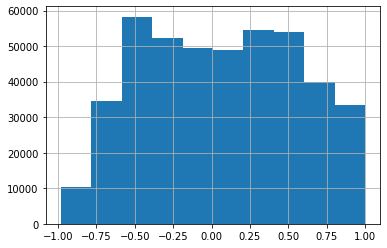

In [169]:
df_c['cor'].hist()

In [160]:
df_out[pd.DataFrame(np.sort(df_out[['symbol','cor']].values,1)).duplicated().values]

,symbol,cor,value
934,3BAL.LON,3CFL.LON,0.243289
1868,3BAL.LON,3IN.LON,0.391466
1869,3CFL.LON,3IN.LON,0.213488
2802,3BAL.LON,3ITS.LON,-0.114722
2803,3CFL.LON,3ITS.LON,0.658207
...,...,...,...
872350,XPP.LON,ZTF.LON,-0.626483
872351,XPS.LON,ZTF.LON,0.528104
872352,XRES.LON,ZTF.LON,-0.768101
872353,ZEG.LON,ZTF.LON,0.666942
